In [92]:
!pip install shap

In [93]:
import pandas as pd
import lightgbm as lgb
import re
import numpy as np
import shap

In [2]:
df_features = pd.read_csv('best_buy_final_features.csv')

In [3]:
len(df_features)

881149

In [123]:
df_features_2 = df_features.drop(['Unnamed: 0', 'SUBCLASS_NAME', 'Any promo today', 'Any promo last week','mean_prev_7_days', 'mean_prev_30_days', 'mean_prev_91_days',
 'mean_prev_365_days','USCS','USUR'], axis=1)
df_features_2.shape

(881149, 40)

In [124]:
# ['Any promo today', 'Any promo last week','mean_prev_7_days', 'mean_prev_30_days', 'mean_prev_91_days',
#  'mean_prev_365_days','USCS','USUR'],

In [125]:
df_features_2 = pd.get_dummies(df_features_2, columns=['CLASS_NAME','ML_NAME','CATEGORY_NAME','Inventory'])
df_features_2.shape

(881149, 76)

In [126]:
encoded = df_features_2.copy()

In [127]:
encoded["SALES_DATE"] = encoded["SALES_DATE"].astype('datetime64[ns]')

In [128]:
encoded['month'] = encoded['SALES_DATE'].dt.month

In [129]:
encoded['year'] = encoded['SALES_DATE'].dt.year

In [130]:
encoded['day'] = encoded['SALES_DATE'].dt.day

In [131]:
encoded['day_of_week'] = encoded['SALES_DATE'].dt.day_of_week

In [132]:
# encoded = encoded.drop(['SALES_DATE','CAST_SALES_DATE','SUBCLASS_NAME','PROMO_PRICE','COMPETITOR_PRICE'], axis=1)
encoded = encoded.drop(['SALES_DATE','CAST_SALES_DATE'], axis=1)

In [133]:
encoded.columns = [re.sub('[^0-9a-zA-Z_]+', '_', col) for col in encoded.columns]

In [134]:
encoded.columns

Index(['Encoded_SKU_ID', 'RETAIL_PRICE', 'PROMO_PRICE', 'COMPETITOR_PRICE',
       'DAILY_UNITS', 'Seasonal_Index', 'Price_ratio', 'Amt_Discount',
       'avg_price_4_weeks', 'avg_price_13_weeks', 'avg_price_26_weeks',
       'avg_price_1_weeks_previous_year', 'avg_price_4_weeks_previous_year',
       'std_dev_4_weeks', 'std_dev_13_weeks', 'std_dev_26_weeks',
       'std_dev_1_weeks_previous_year', 'std_dev_4_weeks_previous_year',
       'PREV_1_DAY_SALES', 'PREV_7_DAY_SALES', 'PREV_30_DAY_SALES',
       'PREV_365_DAY_SALES', 'total_prev_7_days', 'total_prev_30_days',
       'total_prev_91_days', 'total_prev_365_days', 'year_ago_week_sum',
       'year_ago_week_mean', 'GSCPI', 'USIR', 'USPCE', 'covid_new_cases',
       'weather', 'holiday', 'CLASS_NAME_BUILT_IN_COOKING',
       'CLASS_NAME_BUILT_IN_REFRIGERATR', 'CLASS_NAME_CAMERAS_ILC',
       'CLASS_NAME_CAMERAS_P_S', 'CLASS_NAME_CAR_ELECTRONICS',
       'CLASS_NAME_CAR_STEREO', 'CLASS_NAME_DIGITAL_CAMCORDERS',
       'CLASS_NAME_DIG

In [135]:
validation = encoded[(encoded['month'] == 8) & (encoded['year'] == 2022)]

In [136]:
train = encoded[~((encoded['month'] == 8) & (encoded['year'] == 2022))]

In [137]:
X_train = train.drop("DAILY_UNITS", axis=1)
y_train = train["DAILY_UNITS"]
X_test = validation.drop("DAILY_UNITS", axis=1)
y_test = validation["DAILY_UNITS"]

In [138]:
lgb_train = lgb.Dataset(X_train, y_train, feature_name = list(X_train.columns))
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, feature_name= list(X_test.columns))


In [139]:
X_train.columns

Index(['Encoded_SKU_ID', 'RETAIL_PRICE', 'PROMO_PRICE', 'COMPETITOR_PRICE',
       'Seasonal_Index', 'Price_ratio', 'Amt_Discount', 'avg_price_4_weeks',
       'avg_price_13_weeks', 'avg_price_26_weeks',
       'avg_price_1_weeks_previous_year', 'avg_price_4_weeks_previous_year',
       'std_dev_4_weeks', 'std_dev_13_weeks', 'std_dev_26_weeks',
       'std_dev_1_weeks_previous_year', 'std_dev_4_weeks_previous_year',
       'PREV_1_DAY_SALES', 'PREV_7_DAY_SALES', 'PREV_30_DAY_SALES',
       'PREV_365_DAY_SALES', 'total_prev_7_days', 'total_prev_30_days',
       'total_prev_91_days', 'total_prev_365_days', 'year_ago_week_sum',
       'year_ago_week_mean', 'GSCPI', 'USIR', 'USPCE', 'covid_new_cases',
       'weather', 'holiday', 'CLASS_NAME_BUILT_IN_COOKING',
       'CLASS_NAME_BUILT_IN_REFRIGERATR', 'CLASS_NAME_CAMERAS_ILC',
       'CLASS_NAME_CAMERAS_P_S', 'CLASS_NAME_CAR_ELECTRONICS',
       'CLASS_NAME_CAR_STEREO', 'CLASS_NAME_DIGITAL_CAMCORDERS',
       'CLASS_NAME_DIGITAL_CAMERA_ACC

In [140]:
non_decreasing_features = ["Price_ratio", "Amt_Discount","holiday","Seasonal_Index"]
non_increasing_features = []

In [141]:
# monotone_constraints = {'Price_ratio': 1, 'Amt_Discount': 1, 'holiday': 1, 'Seasonal_Index': 1}
monotone_constraints=[1 if i in non_decreasing_features else -1 if i in non_increasing_features else 0 for i in range(X_train.shape[1])]

In [142]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0 
#     'monotone_constraints' : {feature: 1 if feature in non_decreasing_features else -1 if feature in non_increasing_features else 0 for feature in X_train.columns}
#     "monotone_constraints": [-1, 0, 1]
#       "monotone_constraints":monotone_constraints
}

In [143]:
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=5)

# lgb_train.set_monotone_constraints(monotone_constraints)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062195 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [144]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [145]:
# Calculate the mean squared error
mse = np.mean((y_test - y_pred)**2)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 3.687699779565396


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

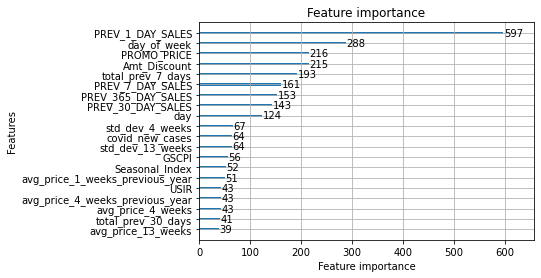

In [146]:
lgb.plot_importance(gbm, max_num_features=20)

In [89]:
encoded['day_of_week'].unique()

array([4, 5, 6, 0, 1, 2, 3], dtype=int64)

In [98]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)

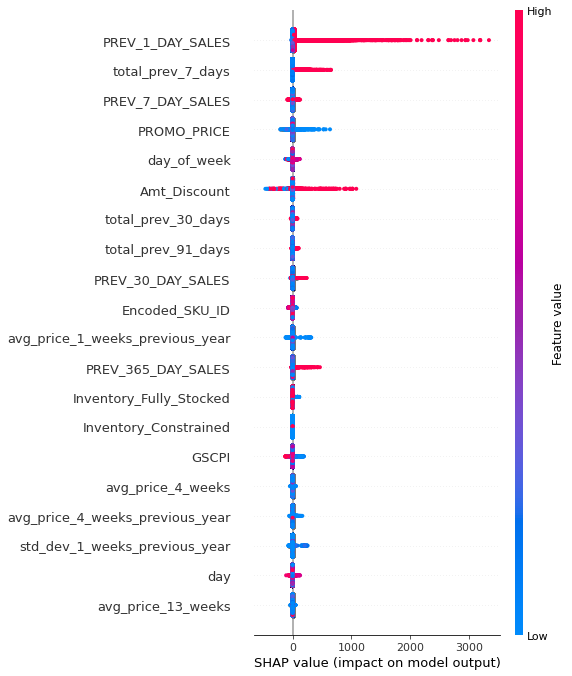

In [99]:
shap.summary_plot(shap_values, X_train)